In [115]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Setting these staticly for consistency across this workbook
decision_tree_depth = 50
train_test_split_perc = 0.3

## Simple decision tree

Performing a simple decision tree for our transaction categorisation using only the Narration column...

In [116]:
transactions = pd.read_csv('test-expense-data.csv', parse_dates=["Transaction Date"], date_format="%d/%m/%Y")
transactions.head()
basic_transactions_x = transactions.drop(["BSB Number","Account Number","Categories","Transaction Date", "Debit", "Credit", "Transaction Type"], axis=1)
basic_transactions_y = transactions['Categories']
# basic_transactions_x.head()
basic_transactions_x_encoded = pd.get_dummies(basic_transactions_x, dtype=int)
basic_X_train, basic_X_test, basic_y_train, basic_y_test = train_test_split(basic_transactions_x_encoded, basic_transactions_y, test_size=train_test_split_perc)
basic_dtree = DecisionTreeClassifier(max_depth=decision_tree_depth)
basic_dtree.fit(basic_X_train, basic_y_train)
basic_train_predictions = basic_dtree.predict(basic_X_train)
basic_test_predictions = basic_dtree.predict(basic_X_test)
basic_train_acc = accuracy_score(basic_y_train, basic_train_predictions)
basic_test_acc = accuracy_score(basic_y_test, basic_test_predictions)
basic_null_acc = basic_y_test.value_counts().iloc[0]/sum(basic_y_test.value_counts())

print(f"\n############\n  ACCURACY  \n############")
print('train acc', basic_train_acc)
print('test acc', basic_test_acc)
print('null accuracy', basic_null_acc)



############
  ACCURACY  
############
train acc 0.6506849315068494
test acc 0.5158730158730159
null accuracy 0.18253968253968253


---

## Pruning 

Our accuracy scores seem low. Let's see if we prune any categories where there are less than 5 transactions.


In [126]:
transactions = pd.read_csv('test-expense-data.csv', parse_dates=["Transaction Date"], date_format="%d/%m/%Y")

cats_of_interest = transactions["Categories"].value_counts()[transactions["Categories"].value_counts() >= 5 ].index
print(f"Categories of interest - {len(cats_of_interest)} of {len(transactions["Categories"].value_counts())}")

print(f"Total Transaction count {len(transactions)}")
filtered_transactions = transactions[transactions["Categories"].isin(cats_of_interest)]
print(f"Filtered Transaction count {len(filtered_transactions)}")

Categories of interest - 20 of 36
Total Transaction count 418
Filtered Transaction count 386


In [127]:
transactions_x = filtered_transactions.drop(["Categories","Transaction Date", "Debit", "Credit", "Transaction Type"], axis=1)
transactions_y = filtered_transactions['Categories']
if transactions_y.isnull().values.any():
    print("ERROR: There are NaN values in transactions_y")

transactions_x_encoded = pd.get_dummies(transactions_x, drop_first=True, dtype=int)

X_train, X_test, y_train, y_test = train_test_split(transactions_x_encoded, transactions_y, test_size=train_test_split_perc)
print("Total size of data:", len(transactions_x_encoded))
print("Size of training data:", len(X_train))
print("Size of test data:", len(X_test))
dtree = DecisionTreeClassifier(max_depth=decision_tree_depth)
dtree.fit(X_train, y_train)
train_predictions = dtree.predict(X_train)
test_predictions = dtree.predict(X_test)
train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
null_acc = y_test.value_counts().iloc[0]/sum(y_test.value_counts())

print(f"\n############\n  ACCURACY  \n############")
print('train acc', train_acc)
print('test acc', test_acc)
print('null accuracy', null_acc)


Total size of data: 386
Size of training data: 270
Size of test data: 116

############
  ACCURACY  
############
train acc 0.7222222222222222
test acc 0.5517241379310345
null accuracy 0.1810344827586207


## Reviewing our data

Let's see the distribution of categories

<Axes: title={'center': 'Category occurrence'}, xlabel='Categories'>

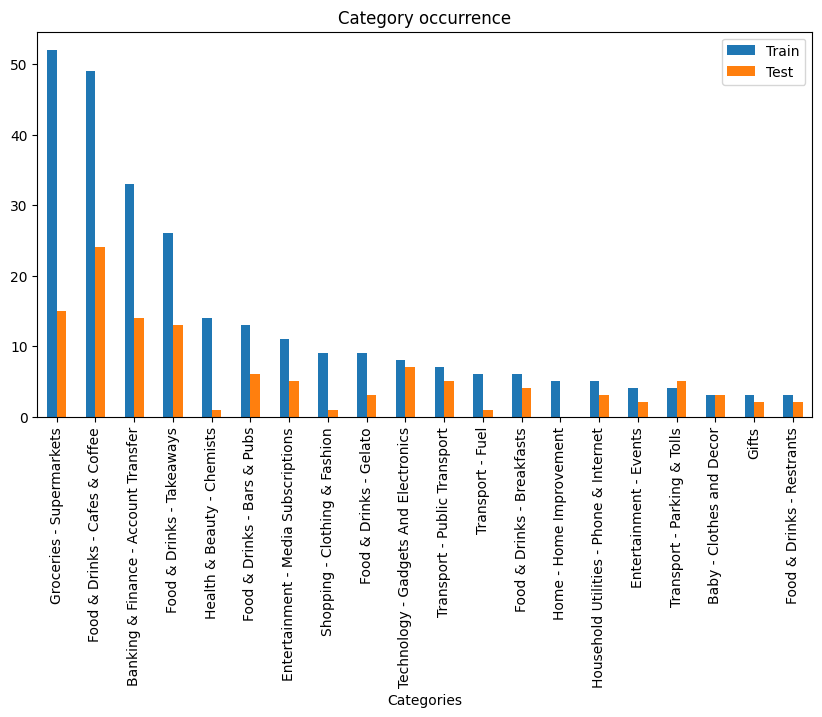

In [119]:
raw_train = filtered_transactions.sample(frac=0.8).sort_index()
raw_test = filtered_transactions[~filtered_transactions.index.isin(raw_train.index)]

accumulated_category_count_transactions = pd.concat([
    y_train.value_counts(),
    y_test.value_counts()],
    axis=1,
    sort=False,
    keys = ["Train", "Test"])
accumulated_category_count_transactions.plot(kind="bar", figsize=(10,5), title="Category occurrence")


In [120]:
print(f"training entries: {len(raw_train)}")
print(f"test entries: {len(raw_test)}")
print(f"number of unique categories (with enough annotations): {len(set(transactions['Categories']))}")

training entries: 309
test entries: 77
number of unique categories (with enough annotations): 36


---

## Simplifying our test data

That didn't seem to make much of a difference...

Since we have categories in the form 'Category - Subcategory' let's see if we strip all the subcategories we get a better result.

In [128]:
transactions = pd.read_csv('test-expense-data.csv', parse_dates=["Transaction Date"], date_format="%d/%m/%Y")
# Do the split
transactions.loc[:,"Categories"] = transactions.loc[:,"Categories"].apply(lambda x: x.split(" - ")[0])

simplified_transactions_x = transactions.drop(["Categories","Transaction Date", "Debit", "Credit", "Transaction Type"], axis=1)
simplified_transactions_y = transactions['Categories']
simplified_transactions_x_encoded = pd.get_dummies(simplified_transactions_x, dtype=int)
simplified_X_train, simplified_X_test, simplified_y_train, simplified_y_test = train_test_split(simplified_transactions_x_encoded, simplified_transactions_y, test_size=train_test_split_perc)
simplified_dtree = DecisionTreeClassifier(max_depth=decision_tree_depth)
simplified_dtree.fit(simplified_X_train, simplified_y_train)
simplified_train_predictions = simplified_dtree.predict(simplified_X_train)
simplified_test_predictions = simplified_dtree.predict(simplified_X_test)
simplified_train_acc = accuracy_score(simplified_y_train, simplified_train_predictions)
simplified_test_acc = accuracy_score(simplified_y_test, simplified_test_predictions)
simplified_null_acc = simplified_y_test.value_counts().iloc[0]/sum(simplified_y_test.value_counts())

print(f"\n############\n  ACCURACY  \n############")
print('train acc', simplified_train_acc)
print('test acc', simplified_test_acc)
print('null accuracy', simplified_null_acc)



############
  ACCURACY  
############
train acc 0.8116438356164384
test acc 0.6825396825396826
null accuracy 0.31746031746031744


<Axes: title={'center': 'Category occurrence'}, xlabel='Categories'>

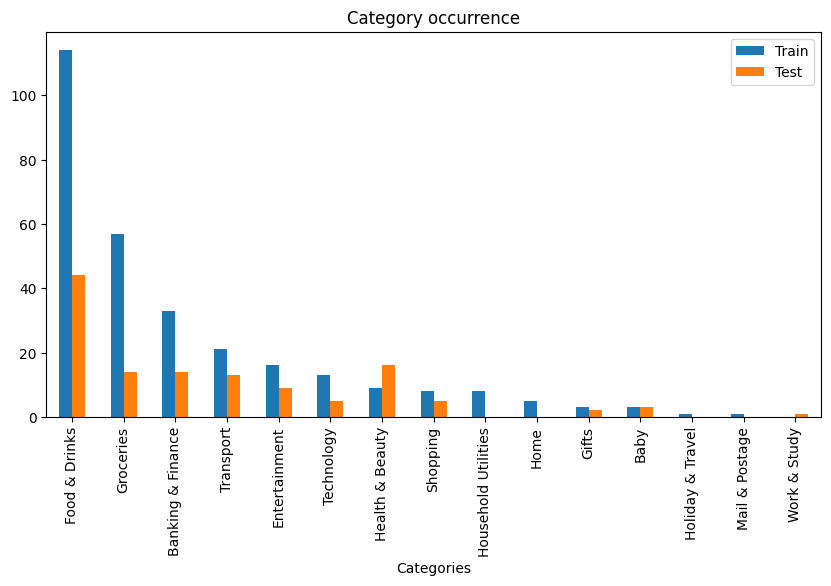

In [122]:
raw_train = transactions.sample(frac=0.8).sort_index()
raw_test = transactions[~transactions.index.isin(raw_train.index)]

accumulated_category_count_transactions = pd.concat([
    simplified_y_train.value_counts(),
    simplified_y_test.value_counts()],
    axis=1,
    sort=False,
    keys = ["Train", "Test"])
accumulated_category_count_transactions.plot(kind="bar", figsize=(10,5), title="Category occurrence")
